# Volcano seismology classification tutorial 

## Learning objectives

By the end of this tutorial, students will be able to load and explore volcano seismic data, extract features from seismic waveforms, build and evaluate classification models, and interpret results for volcano monitoring.

## Chilean volcanoes seismic events

We'll work with the _Multi-station dataset of volcano-seismic events at four volcanoes in Chile_ published on Zenodo by Espinosa-Curilem et al. (2025). This comprehensive dataset contains 24,493 multi-station seismic events recorded at four active Chilean volcanoes between 2013-2019, representing one of the largest publicly available collections of labeled volcano-seismic events.

> Espinosa-Curilem, C., Basualto Alarcón, D. D., & Curilem, M. (2025). Multi-Station Trace Data from four Chilean Volcanoes: Nevados de Chillán Volcanic Complex, Villarrica, Laguna del Maule, and Puyehue-Cordón Caulle. [Data set]. Zenodo. [10.5281/zenodo.17163020](https://doi.org/10.5281/zenodo.17163020)

The dataset was created to advance automated volcano monitoring systems using machine learning, addressing a critical challenge in volcanology: the need for real-time, accurate classification of seismic events to assess volcanic hazards and issue timely warnings to nearby populations. The research aims to develop robust algorithms for automatic event detection and classification, improve early warning systems for volcanic eruptions, and enable continuous monitoring of multiple volcanoes with limited human intervention.

The four volcanoes included are Nevados de Chillán Volcanic Complex (NVCHVC), an active stratovolcano; Villarrica (VCA), one of Chile's most active volcanoes; Llaima (LDM), a highly active basaltic-andesitic volcano; and Calbuco (CAU), an explosive stratovolcano. All are located in the Southern Chilean Andes volcanic arc and were monitored using multi-station seismometer arrays with up to 8 stations per volcano.

The dataset includes five main types of volcanic seismic events, each with distinct characteristics:

| Name                | Acronym | Description                                                                                   |
|---------------------|---------|-----------------------------------------------------------------------------------------------|
| Volcano-Tectonic    | VT      | High-frequency signals caused by rock fracturing and fault movement.                           |
| Long-Period         | LP      | Lower frequency signals associated with fluid movement in volcanic conduits.                   |
| Tremor              | TR      | Sustained oscillatory signals indicating continuous volcanic processes.                        |
| Avalanche           | AV      | Broadband signals from rockfalls and pyroclastic flows.                                       |
| Ice Quake           | IC      | Signals caused by ice fracturing on glacier-covered volcanoes.                                |

Each event is stored as a NumPy array with dimensions 14 × 8,192, where the first 8 rows contain multi-station seismic waveforms sampled at 100 Hz for approximately 82 seconds, and the remaining 6 rows contain event type labels. This technical format allows for comprehensive analysis of both individual station responses and multi-station event characteristics, making it invaluable for developing and benchmarking machine learning algorithms for volcanic hazard assessment.

## Environment

This notebook runs with the essential libraries for data science. Thanks to the work of Espinosa-Curilem et al. (2025), there is no need to install ObsPy or any other seismology library.

In [62]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
%config InlineBacke.nd.figure_format = 'retina'
DATA_DIRECTORY = Path("/gpfs/users/themaster/earth_data_science/datasets/NVCHVC/")
FILES = list(DATA_DIRECTORY.glob("**/*.npy"))
LABELS = {1: "VT", 2: "LP", 3: "TR", 4: "AV", 5: "IC"}

## 1. Dataset format

Understanding data structure is fundamental in any machine learning project. In seismology, data is often recorded simultaneously from multiple sensors (seismometers) placed around a volcano to capture different perspectives of the same seismic event. This multi-station approach provides richer information than single-station recordings but requires careful organization. In order to effectively utilize this data for machine learning, refer to the description in the [Zenodo repository documentation](https://doi.org/10.5281/zenodo.17163020). 

- __Load a sample file__ from the dataset and examine its structure. Use `np.load()` to read one file and print its shape. The sampling rate is 100 Hz, meaning 100 measurements per second. Create a visualization that reveals the data organization. Plot the multi-station waveforms with different vertical offsets so you can see all stations simultaneously. Notice that some stations may have stronger signals than others due to their proximity to the seismic source or local geology effects.

- __Label the waveforms__ with the labels associated with the file recording. The labels are encoded as binary time series: when an event is active, the corresponding label row will have non-zero values. Add colored background regions to your plot to show when and which type of event occurred, helping you understand the relationship between waveform patterns and event classifications.

Data shape: 14 channels x 8192 samples


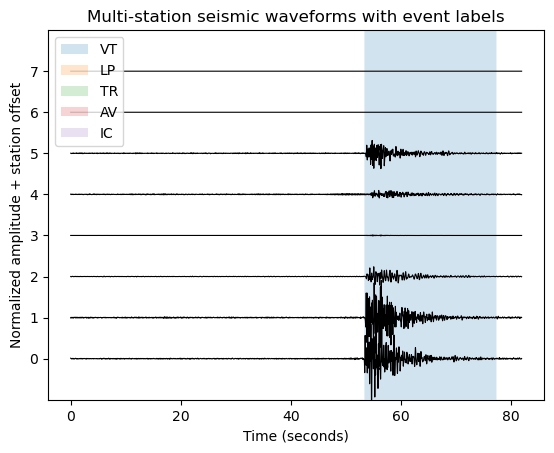

In [3]:
# Randomly select a file
filepath = np.random.choice(FILES)

# Load and inspect the data
sampling_rate = 100
n_stations = 8
data = np.load(filepath)
waveforms = data[:n_stations]
labels = data[n_stations + 1 :]
print(f"Data shape: {data.shape[0]} channels x {data.shape[1]} samples")

# Plot waveforms
fig, ax = plt.subplots(sharex=True)
time = np.arange(data.shape[1]) / sampling_rate
ax.plot(time, waveforms.T + np.arange(8)[None, :], c="k", lw=0.8)

# Label regions
for c, label in enumerate(LABELS.values()):
    ax.fill_between(time, -1, n_stations, labels[c], alpha=0.2, label=label)

# Axes cosmetics
ax.legend()
ax.set(
    xlabel="Time (seconds)",
    ylabel="Normalized amplitude + station offset",
    title="Multi-station seismic waveforms with event labels",
    ylim=(-1, 8),
    yticks=np.arange(8),
)
plt.show()

## 2. Loading event data

In volcano monitoring, seismic stations are distributed around a volcano at various distances and orientations. Due to the complex geology and wave propagation effects, some stations will record cleaner, stronger signals than others for any given event. Rather than arbitrarily choosing a station or trying to analyze all stations simultaneously, a common approach is to automatically select the station with the highest signal amplitude, assuming this represents the clearest recording of the event.

__Create a waveform loader__ called `load_event(filepath)` that processes individual seismic event files. The function loads the .npy file and separates it into waveforms (first rows) and labels (last rows). For each station, it calculates the maximum absolute amplitude of its waveform, which gives you a measure of signal strength. It selects the waveform from the station with the highest amplitude as your "best" signal.

The function should return both the waveform and the corresponding label. To this end, you need to assign a label to the event based on the maximum activity across the label rows.

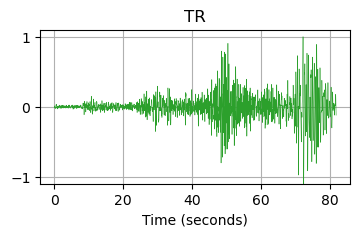

In [117]:
def load_event(filepath, n_stations=8) -> dict:
    """Load a seismic event file and extract the best waveform.

    Parameters
    ----------
    filepath : str or Path
        Path to the .npy file containing seismic event data.
    n_stations : int
        Number of seismic stations (default is 8).

    Returns
    -------
    dict
        A dictionary with keys 'waveform' and 'label'.
    """
    data = np.load(filepath)
    waveforms = data[:n_stations]
    labels = data[n_stations + 1 :]
    amplitudes = np.max(np.abs(waveforms), axis=1)
    best_station = np.argmax(amplitudes)
    # waveform = waveforms[best_station] / np.max(
    #     np.abs(waveforms[best_station])
    # )
    waveform = waveforms[best_station]
    label = LABELS[np.argmax(np.sum(labels, axis=1)) + 1]
    return {"waveform": waveform, "label": label}


def get_color(label):
    """Get a color for a given label."""
    return f"C{list(LABELS.values()).index(label)}"


def plot_event(event, ax=None, show=True, **kwargs):
    """Plot the waveform from the event dictionary."""
    kwargs.setdefault("color", get_color(event["label"]))
    kwargs.setdefault("lw", 0.4)
    waveform = event["waveform"]
    label = event["label"]
    time = np.arange(len(waveform)) / sampling_rate
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 2))
    ax.plot(time, waveform, **kwargs)
    ax.set(
        title=label,
        xlabel="Time (seconds)",
        ylim=[-1.1, 1.1],
        yticks=[-1, 0, 1],
    )
    ax.grid()
    if show:
        plt.show()


# Test the function
event = load_event(np.random.choice(FILES))
plot_event(event)

## 3. Balanced data collection

Class imbalance is a common problem in machine learning that can severely impact model performance. Imagine you have 1000 VT events but only 50 LP events. If you train a model on this unbalanced dataset, it will likely become biased toward predicting VT events simply because it saw many more examples during training. The model might achieve high overall accuracy by always predicting the majority class, but it would fail to recognize the minority classes when they occur.

In volcano monitoring, this is particularly problematic because rare event types (like certain precursors to eruptions) might be the most important to detect correctly, even though they occur infrequently. To address this, we use balanced sampling, collecting equal numbers of examples from each class.

- __Create a function__ `collect_balanced_data(volcano_path, n_per_class=400)` that ensures fair representation. The dataset is organized into subdirectories by event type (VT, LP, TR, AV, IC). Iterate through each subdirectory and use `glob('*.npy')` to find all available event files.

- __Randomly sample exactly `n_per_class` files__ from each event type using `np.random.choice` (set `np.random.seed(42)` for reproducible results). Since some classes may have thousands of examples while others have fewer, this approach ensures equal representation.

- __Organize metadata into a pandas DataFrame__ using your `load_event_file()` function to extract information for each selected file. Create a bar plot showing the final class distribution - you should see equal bars for each event type, confirming your balanced sampling worked correctly.


Collected 2499 events total


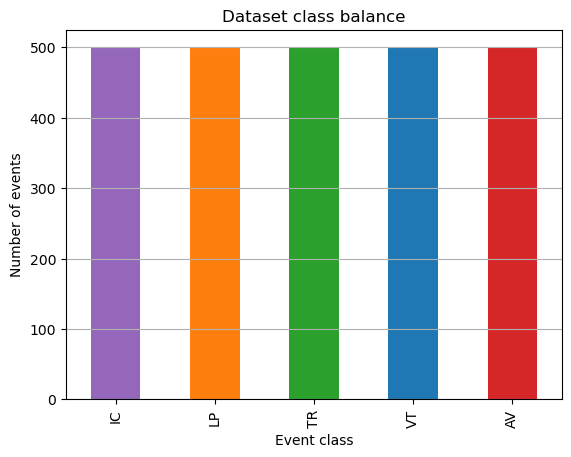

In [118]:
def collect_balanced_data(dirpath, n_per_class=20):
    """Collect balanced samples from each event type."""
    np.random.seed(42)
    events = []
    for event_dir in dirpath.iterdir():
        if event_dir.is_dir():
            files = list(event_dir.glob("*.npy"))
            n_sample = min(n_per_class, len(files))
            if n_sample > 0:
                files = np.random.choice(files, n_sample, replace=False)
                for filepath in files:
                    try:
                        events.append({**load_event(filepath)})
                    except:
                        pass
    return pd.DataFrame(events)


# Collect the data
events = collect_balanced_data(DATA_DIRECTORY, n_per_class=500)
print(f"\nCollected {len(events)} events total")

# Summary
colors = [get_color(label) for label in events.label.unique()]
ax = events.label.value_counts(sort=False).plot.bar(color=colors)
ax.grid(axis="y")
ax.set(
    ylabel="Number of events",
    xlabel="Event class",
    title="Dataset class balance",
)
plt.show()

## 4. Visualizing seismic signals

Before designing machine learning features, it's crucial to visually examine your data to understand the underlying patterns. Different volcanic processes generate distinct seismic signatures that reflect their physical mechanisms. By visualizing waveforms from each event type, you can develop intuition about which characteristics might be useful for automatic classification.

For example, volcano-tectonic (VT) events are caused by rock fracturing and typically produce sharp, high-frequency signals with clear onset times. Long-period (LP) events, caused by fluid movement in volcanic conduits, tend to show lower frequencies and longer durations. Tremor (TR) represents sustained oscillations from continuous processes, while avalanche (AV) events from rockfalls produce broadband signals with variable characteristics. Ice quakes (IC) from glacier fracturing often resemble VT events but may be shorter in duration.

- __Create a comparative visualization__ by selecting one example from each event class in your balanced dataset. Use subplots to display all five event types side by side for easy comparison.

- __Normalize each waveform__ by its maximum absolute amplitude so you can compare shapes rather than just amplitudes. Create a proper time axis from 0 to 81.92 seconds for each plot.

- __Examine the visual patterns__ for differences in frequency content (how rapidly the signal oscillates), signal duration (how long the activity lasts), onset characteristics (sharp vs gradual starts), and overall envelope shapes. These visual patterns will guide your choice of mathematical features in the next section.

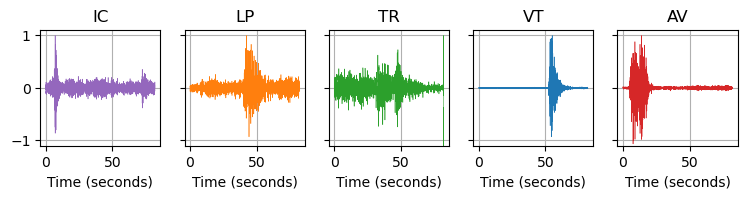

In [122]:
classes = events.label.unique()
n_classes = len(classes)
fig, ax = plt.subplots(
    1, n_classes, figsize=(9, 1.5), sharex=True, sharey=True
)
for i, label in enumerate(classes):
    plot_event(
        events[events["label"] == label].sample(1).iloc[0],
        ax=ax[i],
        show=False,
    )
plt.show()

## 5. Feature extraction

Machine learning algorithms cannot work directly with raw time series data. They need numerical features that capture the essential characteristics of each waveform. The art of feature extraction lies in choosing measurements that highlight the differences you observed visually between event types while ignoring irrelevant variations.

Based on your visual analysis, you likely noticed that different event types vary in their amplitude patterns and frequency content. Time-domain features capture amplitude characteristics: the mean amplitude tells you about the overall signal level, while the standard deviation measures how much the signal varies around this mean. Maximum and minimum values capture the signal's dynamic range, and the root mean square (RMS) provides a measure of the signal's energy content.

Frequency-domain features reveal the spectral characteristics that distinguish event types. The Fast Fourier Transform decomposes the time signal into its frequency components, revealing whether energy is concentrated at high frequencies (like VT events) or low frequencies (like LP events).

- __Design a feature extractor__ function named `extract_features(waveform)` that computes several features in total that you find relevant. 

- __Test your function__ on a sample event and examine the feature values - do they make sense given what you know about that event type?

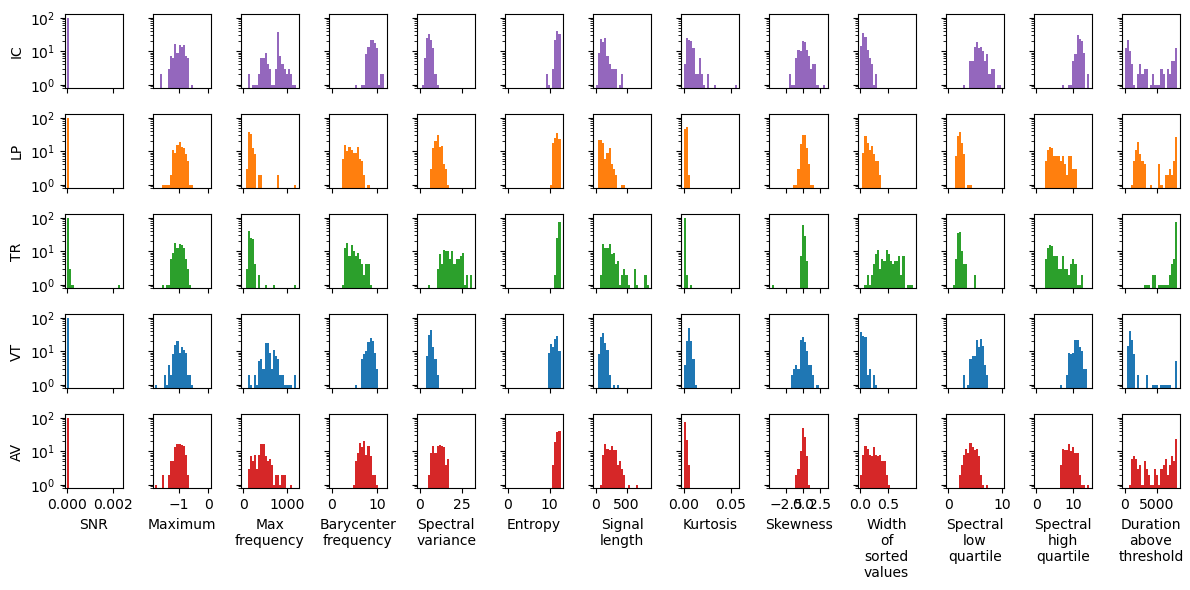

In [126]:
from scipy.signal import hilbert, savgol_filter


def get_spectrum(waveform, sampling_interval=0.01):
    """Compute the spectral barycenter of a waveform."""
    spectrum = np.abs(np.fft.fft(waveform))[: len(waveform) // 2]
    frequencies = np.fft.fftfreq(len(waveform), sampling_interval)[
        : len(waveform) // 2
    ]
    return spectrum, frequencies


def spectral_barycenter(waveform, sampling_interval=0.01):
    """Compute the spectral barycenter of a waveform."""
    spectrum, frequencies = get_spectrum(waveform, sampling_interval)
    return np.sum(spectrum * frequencies) / np.sum(spectrum)


def spectral_low_quartile(waveform, sampling_interval=0.01):
    """Compute the spectral low quartile of a waveform."""
    spectrum, frequencies = get_spectrum(waveform, sampling_interval)
    cumulative_energy = np.cumsum(spectrum)
    total_energy = cumulative_energy[-1]
    low_quartile_index = np.where(cumulative_energy >= 0.25 * total_energy)[0][
        0
    ]
    return frequencies[low_quartile_index]


def spectral_high_quartile(waveform, sampling_interval=0.01):
    """Compute the spectral high quartile of a waveform."""
    spectrum, frequencies = get_spectrum(waveform, sampling_interval)
    cumulative_energy = np.cumsum(spectrum)
    total_energy = cumulative_energy[-1]
    high_quartile_index = np.where(cumulative_energy >= 0.75 * total_energy)[
        0
    ][0]
    return frequencies[high_quartile_index]


def waveform_entropy(waveform):
    """Compute the waveform entropy."""
    p = np.abs(waveform) / np.sum(np.abs(waveform))
    return -np.sum(p * np.log2(p + 1e-10))


def signal_length(waveform):
    """Compute the signal length of a waveform."""
    return np.sum(np.abs(np.diff(waveform)))


def kurtosis(waveform):
    """Compute the kurtosis of a waveform."""
    n = len(waveform)
    mean = np.mean(waveform)
    std = np.std(waveform)
    return (n * np.sum((waveform - mean) ** 4)) / (
        (n - 1) * (n - 2) * (n - 3) * (std**4)
    )


def skewness(waveform):
    """Compute the skewness of a waveform."""
    n = len(waveform)
    mean = np.mean(waveform)
    std = np.std(waveform)
    return (n * np.sum((waveform - mean) ** 3)) / (
        (n - 1) * (n - 2) * (std**3)
    )


# Finder another
def width_of_sorted_values(waveform):
    """Compute the width of sorted values of a waveform."""
    sorted_values = np.sort(waveform)
    return (
        sorted_values[int(0.9 * len(sorted_values))]
        - sorted_values[int(0.1 * len(sorted_values))]
    )


def kind_of_duration(waveform, threshold=0.1):
    """Compute the duration of a waveform above a certain threshold."""
    envelope = np.abs(hilbert(waveform))
    smoothed_envelope = savgol_filter(envelope, window_length=51, polyorder=3)
    above_threshold = np.where(smoothed_envelope >= threshold)[0]
    if len(above_threshold) == 0:
        return 0
    return above_threshold[-1] - above_threshold[0]


def snr(waveform):
    """Compute the signal-to-noise ratio of a waveform."""
    signal_power = np.mean(waveform**2)
    noise_power = np.var(waveform - np.mean(waveform))
    return 10 * np.log10(signal_power / noise_power + 1e-10)


def median_over_shot(waveform):
    """Compute the median over shot of a waveform."""
    return np.median(waveform)


feature_fun = {
    # "Average": np.mean,
    # "Deviation": np.std,
    "SNR": snr,
    "Maximum": np.min,
    # "Minimum": np.min,
    # "RMS": lambda x: np.sqrt(np.mean(x**2)),
    "Max frequency": lambda x: get_spectrum(x)[0].argmax(),
    "Barycenter frequency": lambda x: spectral_barycenter(x),
    "Spectral variance": lambda x: get_spectrum(x)[0].std(),
    "Entropy": lambda x: waveform_entropy(x),
    "Signal length": lambda x: signal_length(x),
    "Kurtosis": lambda x: kurtosis(x),
    "Skewness": lambda x: skewness(x),
    "Width of sorted values": lambda x: width_of_sorted_values(x),
    "Spectral low quartile": lambda x: spectral_low_quartile(x),
    "Spectral high quartile": lambda x: spectral_high_quartile(x),
    "Duration above threshold": lambda x: kind_of_duration(x),
}


def extract_features(waveform):
    """Extract features from a seismic waveform."""
    features = [func(waveform) for func in feature_fun.values()]
    return np.array(features)


# Distribution of features
n_samples = 100
features = np.zeros((len(events), n_samples, len(feature_fun)))
for i, label in enumerate(classes):
    event_set = events[events["label"] == label].iloc[:n_samples]
    extracted = [extract_features(e) for e in event_set.waveform]
    features[i, :, :] = np.array(extracted)
    features[i, ...][np.isnan(features[i, ...])] = 0

# Plot
fig, ax = plt.subplots(
    len(LABELS), len(feature_fun), figsize=(12, 6), sharex="col", sharey=True
)
for i, label in enumerate(classes):
    ax[i, 0].set_ylabel(label)
    for j, (name, _) in enumerate(feature_fun.items()):
        ax[-1, j].set_xlabel("\n".join(name.split(" ")))
        bins = np.histogram_bin_edges(features[..., j], bins=25)
        ax[i, j].hist(features[i, :, j], bins=bins, color=get_color(label))
        ax[i, j].set_yscale("log")
fig.tight_layout()

## 6. Building the feature matrix

Scikit-learn and most machine learning libraries expect data in a specific format: a feature matrix X where each row represents one sample (event) and each column represents one feature, paired with a label vector y containing the corresponding class labels. This standardized format allows algorithms to efficiently process large datasets and makes it easy to split data for training and testing.

The transformation from individual files to this matrix format requires systematic processing of your entire dataset. You'll need to apply your feature extraction function to every event in your balanced collection, accumulating the results into the proper arrays.

- __Process your entire balanced dataset__ by initializing empty lists for features (X) and labels (y). Loop through each row in your `events_df` using `iterrows()`, and for each event: load the file, extract the 8 features, and append both to your growing lists.

- __Include error handling__ with try/except blocks to gracefully skip any problematic files that might be corrupted or incorrectly formatted - this is important when working with real-world datasets.

- __Verify your data preparation__ by converting to numpy arrays and checking shapes: X should be [n_samples, 8] and y should be [n_samples]. Use `np.unique(y, return_counts=True)` to confirm you still have balanced classes after processing.

In [124]:
# Design and label matrix
x = []
y = []
for waveform, label in events.itertuples(index=False):
    features = extract_features(waveform)
    x.append(features)
    y.append(label)
x = np.array(x)
y = np.array(y)

# Summary
print(f"Feature matrix shape: {x.shape}, labels shape: {y.shape}")

Feature matrix shape: (2499, 12), labels shape: (2499,)


## 7. Training classification models

Different machine learning algorithms make different assumptions about data patterns and use different mathematical approaches to learn decision boundaries. Since we don't know a priori which approach will work best for volcano event classification, it's standard practice to compare multiple algorithms and select the best performer.

Random Forest builds many decision trees and combines their predictions through voting. It's particularly good at handling non-linear relationships and interactions between features. Support Vector Machine (SVM) tries to find the optimal boundary that separates classes with maximum margin and can capture complex decision boundaries. Logistic Regression assumes linear relationships between features and class probabilities. While simple, it's fast, interpretable, and provides a good baseline.

- __Split your data__ using `train_test_split` with stratification to maintain class balance in both training and test sets (use `test_size=0.3, random_state=42, stratify=y`).

- __Apply feature scaling__ with `StandardScaler` - fit it only on training data to avoid data leakage, then transform both training and test sets. This is particularly important for SVM which is sensitive to feature scales.

- __Train and compare three classifiers__: RandomForestClassifier, SVC, and LogisticRegression. For each, train on scaled training data, make predictions on the test set, and calculate accuracy. The model with highest test accuracy will be your best choice for volcano monitoring.

In [125]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Training set: {len(x_train)} samples")
print(f"Test set: {len(x_test)} samples\n")

# Try different classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    # "MLP": MLPClassifier(max_iter=2000, hidden_layer_sizes=(6, 4)),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=500),
}

best_score = 0
best_model = None
best_name = ""

for name, model in classifiers.items():
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: {accuracy:.3f} accuracy", flush=False)
    if accuracy > best_score:
        best_score = accuracy
        best_model = model
        best_name = name
        best_pred = y_pred

print(f"\nBest model: {best_name} ({best_score:.3f} accuracy)")

Training set: 1749 samples
Test set: 750 samples

Random Forest: 0.799 accuracy
SVM: 0.776 accuracy
Logistic Regression: 0.773 accuracy
KNN: 0.743 accuracy

Best model: Random Forest (0.799 accuracy)


## 8. Evaluating model performance

A single accuracy number doesn't tell the full story of model performance, especially for multi-class problems. In volcano monitoring, the consequences of misclassification vary. Confusing a VT event with an LP event might indicate a different stage of volcanic unrest than confusing it with background noise. Understanding which specific errors your model makes is crucial for assessing its reliability in operational settings.

The confusion matrix is the key diagnostic tool for multi-class classification. It's a square matrix where rows represent true classes and columns represent predicted classes. Perfect classification would show all counts on the diagonal (correct predictions) with zeros elsewhere. Off-diagonal elements reveal specific confusion patterns that suggest these classes share similar feature patterns.

- __Create a confusion matrix visualization__ using `ConfusionMatrixDisplay` with proper class labels (VT, LP, TR, AV, IC) and an appropriate color scheme like 'RdPu'. Include the model name and accuracy percentage in the title.

- __Print a detailed classification report__ using `classification_report()` which provides precision (fraction of predicted events that were correct), recall (fraction of actual events correctly identified), and F1-score (harmonic mean of precision and recall) for each class.

- __Analyze the results systematically__ by identifying event types that are consistently well-classified versus problematic ones. Consider why certain confusion pairs occur and their implications for volcano monitoring safety.

              precision    recall  f1-score   support

          AV       0.84      0.81      0.82       150
          IC       0.72      0.84      0.78       150
          LP       0.80      0.89      0.84       150
          TR       0.90      0.83      0.86       150
          VT       0.77      0.63      0.69       150

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750



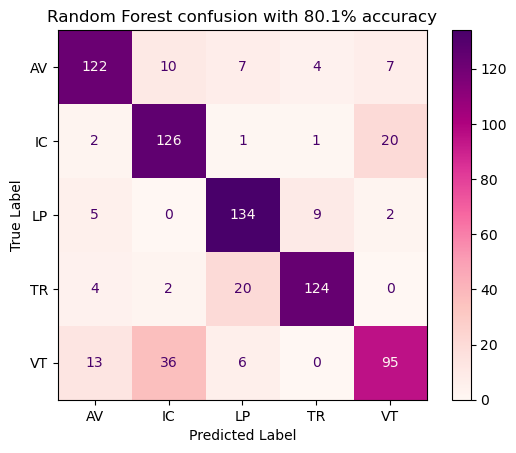

In [112]:
cm = confusion_matrix(y_test, best_pred)
ax = ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(cmap="RdPu")
ax.ax_.set(title=f"{best_name} confusion with {best_score:.1%} accuracy")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Classification report
print(classification_report(y_test, best_pred))

## 9. Random Forest feature importance analysis

Even if Random Forest didn't win the performance contest, it provides a unique advantage that other algorithms cannot offer: interpretable feature importance scores. This capability makes Random Forest invaluable for understanding which seismic characteristics are most discriminative for volcanic event classification, regardless of its ranking in accuracy.

Feature importance in Random Forest is calculated by measuring how much each feature contributes to decreasing impurity (uncertainty) when making splits across all decision trees in the forest. Features that consistently help separate different event types receive higher importance scores. This interpretability helps seismologists understand the underlying physics of volcanic processes and can guide future feature engineering or sensor deployment strategies.

For volcano monitoring, knowing whether time-domain features (like amplitude statistics) or frequency-domain features (like spectral characteristics) are more important can provide insights into the physical mechanisms generating different types of volcanic signals.

Random Forest accuracy: 0.795


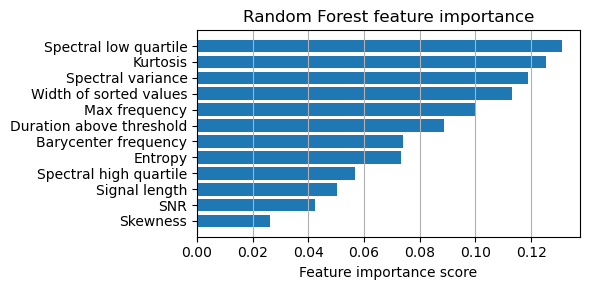

In [113]:
# Retrain Random Forest specifically for feature importance analysis
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(x_train_scaled, y_train)

# Calculate accuracy to show performance
rf_pred = rf_model.predict(x_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest accuracy: {rf_accuracy:.3f}")

# Extract feature importance scores
importances = rf_model.feature_importances_
feature_names = list(feature_fun.keys())

# Create feature importance visualization
fig, ax = plt.subplots(figsize=(6, 3))
indices = np.argsort(importances)[::-1]
bars = ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
ax.set_yticklabels([feature_names[i] for i in indices])
ax.set_xlabel("Feature importance score")
ax.set_title("Random Forest feature importance")
ax.invert_yaxis()
ax.grid(axis="x")
plt.tight_layout()
plt.show()

## Conclusion and perspectives

This notebook provided a practical introduction to machine learning for volcano seismology, covering the workflow from data loading and exploration to feature extraction, model training, evaluation, and interpretation. Using a large, labeled dataset of multi-station volcanic events, we engineered both time-domain and frequency-domain features, built and compared several classifiers, and analyzed feature importance to understand which signal characteristics are most useful for distinguishing event types.

Key steps included balancing the dataset to avoid class bias, visualizing waveform differences, and extracting statistical and spectral features. Random Forest, SVM, and Logistic Regression models were evaluated, with performance assessed using accuracy, confusion matrices, and classification reports. Feature importance analysis highlighted which aspects of the seismic signals contributed most to classification.

While the approach here uses basic features and classical machine learning, future improvements could include advanced feature extraction (e.g., wavelets, cepstral coefficients), deep learning for automatic feature discovery, and leveraging multi-station coherence. Real-time deployment would require efficient algorithms and uncertainty quantification. The Chilean volcanic event dataset offers a strong foundation for exploring these directions and advancing automated volcano monitoring.

### References

- Ohrnberger, M. (2001). Continuous automatic classification of seismic signals of volcanic origin at Mt. Merapi, Java, Indonesia. PhD thesis, University of Potsdam.

- Perol, T., Gharbi, M., & Denolle, M. (2018). Convolutional neural network for earthquake detection and location. *Science Advances*, 4(2), e1700578.

- Maggi, A., Tape, C., Chen, M., Chao, D., & Tromp, J. (2009). An automated time‐window selection algorithm for seismic tomography. *Geophysical Journal International*, 178(1), 257-281.
